In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib


import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [5]:
batch_size_train = 128
batch_size_test = 16
img_size = 28

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x*255)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

torch.Size([16, 1, 28, 28])


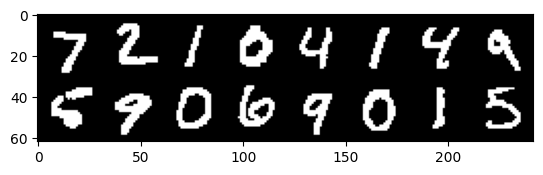

In [6]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(test_loader)
images, lables = next(dataiter)
print(images.shape)

imshow(torchvision.utils.make_grid(images))

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

class SelfAttention(nn.Module):
  def __init__(self, dim, heads):
    super(SelfAttention, self).__init__()
    self.heads = heads

    assert dim % heads == 0

    self.dim, self.heads = dim, heads
    # for scaled dot product: W' = Q @ K.T / sqrt(dim)
    self.scale = dim ** 0.5

    self.tokeys = nn.Linear(dim, dim, bias=False)
    self.toqueries = nn.Linear(dim, dim, bias=False)
    self.tovalues = nn.Linear(dim, dim, bias=False)
    self.unifyheads = nn.Linear(dim, dim)


  def forward(self, x):
    batch, t, dim = x.size()
    h = self.heads
    s = dim // h

    queries = self.toqueries(x)
    keys = self.tokeys(x)
    values = self.tovalues(x)

    queries = queries.view(batch, t, h, s)
    keys = keys.view(batch, t, h, s)
    values = values.view(batch, t, h, s)

    queries = queries.transpose(1,2).contiguous().view(batch * h, t, s)
    keys = keys.transpose(1,2).contiguous().view(batch * h, t, s)
    values = values.transpose(1,2).contiguous().view(batch * h, t, s)

    attention = torch.bmm(queries, keys.transpose(1,2))
    attention = attention / self.scale
    attention = attention.softmax(dim=-1)

    out = torch.bmm(attention, values).view(batch, h, t, s)
    out = out.transpose(1,2).contiguous().view(batch, t, s*h)

    return self.unifyheads(out)


In [8]:
class TransformerBlock(nn.Module):
  def __init__(self, dim, heads):
    super(TransformerBlock, self).__init__()
    self.attention = SelfAttention(dim, heads)

    self.norm_1 = nn.LayerNorm(dim)
    self.norm_2 = nn.LayerNorm(dim)

    self.mlp = nn.Sequential(
      nn.Linear(dim, dim * 4),
      nn.ReLU(),
      nn.Linear(dim * 4, dim)
    )

  def forward(self, x):
    self_attention = self.attention(x)
    x = self.norm_1(self_attention + x)
    ff = self.mlp(x)

    return self.norm_2(ff + x)


In [9]:
class ViT(nn.Module):
  def __init__(self, image_size=28, patch_size=7, num_classes=10, dim=256, depth=6, heads=8):
    super(ViT, self).__init__()
    self.patch_size = patch_size
    self.dim = dim
    self.num_classes = num_classes

    # Input -> Embedding -> Transformer block (self-attention -> layer normalization -> feed forward -> layer normalization)
    # Splitting the images with (7,7) patch. Returns size ([batch_size, dim, img_size/patch_size, img_size/patch_size])
    self.embedding = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)

    self.transformer_blocks = nn.ModuleList([
        TransformerBlock(dim, heads) for _ in range(depth)
    ])

    self.fc = nn.Linear(dim, num_classes)

  def forward(self, x):
    x = self.embedding(x)
    x = x.reshape(x.size(0), -1, self.dim)

    for transformer_block in self.transformer_blocks:
        x = transformer_block(x)
    x = x.mean(dim=1)
    x = self.fc(x)
    return x

In [10]:
saved_params_path = "./saved_params_ViT"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

num_epochs = 50
lr = 3e-4

vit_model = ViT().to(device)
print(vit_model)

CE_loss =nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=3e-4)


for epoch in range(num_epochs):
  for batch_idx, (x, labels) in enumerate(train_loader, 0):
    x = x.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = vit_model.forward(x)

    loss = CE_loss(outputs, labels)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{num_epochs}, Cross Entropy Loss: {loss.item():.2f}")
  torch.save(vit_model.state_dict(), f'{saved_params_path}/{epoch}.pth')


# Save the trained model
torch.save(vit_model.state_dict(), 'final_ViT.pth')

ViT(
  (embedding): Conv2d(1, 256, kernel_size=(7, 7), stride=(7, 7))
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=256, out_features=256, bias=False)
        (toqueries): Linear(in_features=256, out_features=256, bias=False)
        (tovalues): Linear(in_features=256, out_features=256, bias=False)
        (unifyheads): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)
Epoch 1/50, Cross Entropy Loss: 0.12
Epoch 2/50, Cross Entropy Loss: 0.11
Epoch 3/50, Cross Entropy Loss: 0.17
Epoch 4/50, C

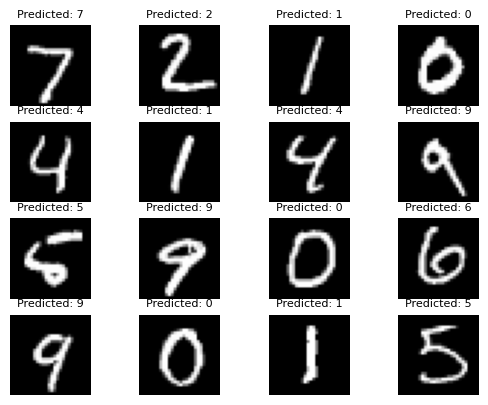

Accuracy : 98.01%


In [11]:
vit_model.eval()

batch = next(iter(test_loader))
images, labels = batch

outputs = vit_model(images.to(device))
_, prediction = torch.max(outputs.data, 1)

for i in range(16):
  image = images[i].numpy().squeeze()
  plt.subplot(4,4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Predicted: {prediction[i]}', fontsize= 8)
  plt.axis('off')
plt.show()


with torch.no_grad():
  correct = 0
  total = 0
  for img, labels in test_loader:
    outputs = vit_model(img.to(device))
    labels = labels.to(device)
    _, prediction = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (prediction == labels).sum().item()
  print(f'Accuracy : {100 * correct / total}%')
